# Tradução Neural de Máquina Inglês para Português com Tensorflow 2

### Por João Victor Almeida - Universidade Federal Fluminense

## Sobre a base de dados Europarl

#### A base Europarl é um compilado de transcrições de sessões do parlamento europeu entre 1996 e 2011 disponível em 21 línguas europeias.

#### Mais informações sobre a base podem ser encontradas em http://www.statmt.org/europarl/

#### Outras bases podem ser encontradas em http://matrix.statmt.org/test_sets/list

## Bibliotecas necessárias

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from tqdm import tqdm
from collections import Counter
from sklearn.model_selection import train_test_split

import re
import os
import time
import json
import math
import tarfile
import unicodedata

## Download e extração da base de dados

### Acessando o Google Drive a partir do Colab

#### Observações :
##### 1 - O caminho '/content/gdrive/My\ Drive/' é em inglês e padrão, independentemente da língua em que seu Google Drive está.

##### 2 - A parte do caminho 'TCC/Europarl/' é pessoal. Você pode usar a pasta que quiser.

##### 3 - Para usar o comando wget é necessário colocar '\\' antes de qualquer espaço.

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/')
raiz = '/content/gdrive/My\ Drive/TCC/Europarl/'

Mounted at /content/gdrive/


### Baixando a base de dados Europarl PT-EN pro Google Drive

In [ ]:
!wget 'http://www.statmt.org/europarl/v7/pt-en.tgz' -P $raiz

--2020-11-08 02:54:55--  http://www.statmt.org/europarl/v7/pt-en.tgz
Resolving www.statmt.org (www.statmt.org)... 129.215.197.184
Connecting to www.statmt.org (www.statmt.org)|129.215.197.184|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 197738765 (189M) [application/x-gzip]
Saving to: ‘/content/gdrive/My Drive/TCC/Europarl/pt-en.tgz’

pt-en.tgz           100%[===================>] 188.58M   584KB/s    in 13m 36s 

2020-11-08 03:08:31 (237 KB/s) - ‘/content/gdrive/My Drive/TCC/Europarl/pt-en.tgz’ saved [197738765/197738765]



### Extraindo os arquivos

In [ ]:
raiz = '/content/gdrive/My Drive/TCC/Europarl/' # retirando o '\' antes do espaço pois não será mais necessário

In [ ]:
tgz = tarfile.open(raiz + 'pt-en.tgz', 'r')

for arquivo in tgz:
    tgz.extract(arquivo, raiz)

### Listando os arquivos que compõem a base de dados

In [ ]:
os.listdir(raiz)

['pt-en.tgz', 'europarl-v7.pt-en.en', 'europarl-v7.pt-en.pt']

## Análise exploratória da base Europarl PT-EN

### Carregando os arquivos

In [ ]:
europarl_pt = []
with open(raiz + "europarl-v7.pt-en.pt", "r") as arquivo:
    europarl_pt = [linha.strip() for linha in arquivo]

europarl_en = []
with open(raiz + "europarl-v7.pt-en.en", "r") as arquivo:
    europarl_en = [linha.strip() for linha in arquivo]

### Conferindo o número de linhas em cada arquivo

In [ ]:
print('Número total de linhas em português : ' + str(len(europarl_pt)))
print('Número total de linhas em inglês : ' + str(len(europarl_en)))

Número total de linhas em português : 1960407
Número total de linhas em inglês : 1960407


### Alguns trechos da base

In [ ]:
print(europarl_pt[0])
print(europarl_pt[1])
print(europarl_pt[2])

Reinício da sessão
Declaro reaberta a sessão do Parlamento Europeu, que tinha sido interrompida na sexta-feira, 17 de Dezembro último, e renovo todos os meus votos, esperando que tenham tido boas férias.
Como puderam constatar, o grande "bug do ano 2000" não aconteceu. Em contrapartida, os cidadãos de alguns dos nossos países foram vítimas de catástrofes naturais verdadeiramente terríveis.


In [ ]:
print(europarl_en[0])
print(europarl_en[1])
print(europarl_en[2])

Resumption of the session
I declare resumed the session of the European Parliament adjourned on Friday 17 December 1999, and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period.
Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful.


### Contando a quantidade de ocorrências de cada palavra no vocabulário

##### Tirado de : https://machinelearningmastery.com/prepare-french-english-dataset-machine-translation/

#### Em português

In [ ]:
pbar = tqdm(total = len(europarl_pt))
counter_vocabulario_pt = Counter()

for linha in europarl_pt:
    linha_com_pontuacao_espacada = linha.replace(',', ' , ').replace('.', ' . ').replace('!', ' ! ').replace('?', ' ? ').replace('  ', ' ').replace('   ', ' ')
    counter_vocabulario_pt.update(linha_com_pontuacao_espacada.split(' '))
    pbar.update(1)
pbar.close()

del(counter_vocabulario_pt[''])
vocabulario_pt = [vocabulo for (vocabulo, cont) in counter_vocabulario_pt.items()]
cont_vocabulario_pt = [cont for (vocabulo, cont) in counter_vocabulario_pt.items()]

100%|██████████| 1960407/1960407 [00:25<00:00, 77741.85it/s]


#### Em inglês

In [ ]:
pbar = tqdm(total = len(europarl_en))
counter_vocabulario_en = Counter()

for linha in europarl_en:
    linha_com_pontuacao_espacada = linha.replace(',', ' , ').replace('.', ' . ').replace('!', ' ! ').replace('?', ' ? ').replace('  ', ' ').replace('   ', ' ')
    counter_vocabulario_en.update(linha_com_pontuacao_espacada.split(' '))
    pbar.update(1)
pbar.close()

del(counter_vocabulario_en[''])
vocabulario_en = [vocabulo for (vocabulo, cont) in counter_vocabulario_en.items()]
cont_vocabulario_en = [cont for (vocabulo, cont) in counter_vocabulario_en.items()]

100%|██████████| 1960407/1960407 [00:21<00:00, 90425.08it/s]


### Tamanho do vocabulário português

In [ ]:
print(str(len(vocabulario_pt)) + " vocábulos")

286945 vocábulos


### Tamanho do vocabulário inglês

In [ ]:
print(str(len(vocabulario_en)) + " vocábulos")

209071 vocábulos


### 20 ocorrências mais comuns no vocabulário português

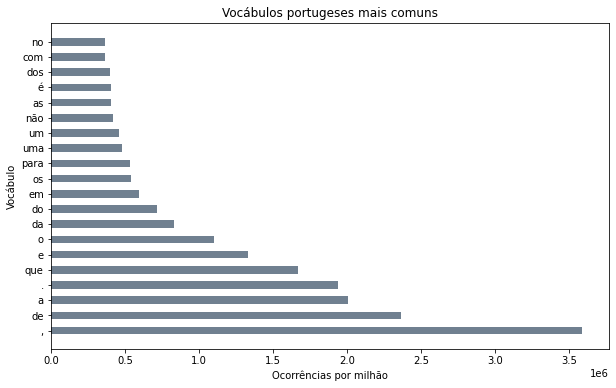

In [ ]:
temp_vocab_pt = sorted(zip(cont_vocabulario_pt, vocabulario_pt), reverse=True)

vocabulario_pt = [vocabulo for (cont, vocabulo) in temp_vocab_pt]
cont_vocabulario_pt = [cont for (cont, vocabulo) in temp_vocab_pt]

plt.figure(figsize=(10, 6))
plt.barh([i for i in range(20)], [cont_vocabulario_pt[i] for i in range(20)], color='slategrey', height=0.5)
plt.ylabel("Vocábulo")
plt.xlabel("Ocorrências por milhão")
plt.title("Vocábulos portugeses mais comuns")
plt.yticks([i for i in range(20)], [vocabulario_pt[i] for i in range(20)])

plt.show()

### 20 palavras mais comuns no vocabulário inglês

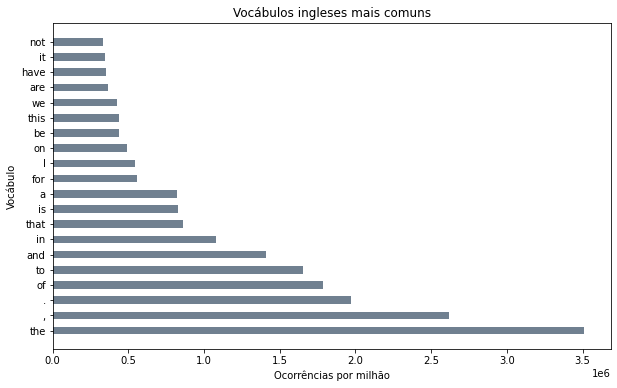

In [ ]:
temp_vocab_en = sorted(zip(cont_vocabulario_en, vocabulario_en), reverse=True)

vocabulario_en = [vocabulo for (cont, vocabulo) in temp_vocab_en]
cont_vocabulario_en = [cont for (cont, vocabulo) in temp_vocab_en]

plt.figure(figsize=(10, 6))
plt.barh([i for i in range(20)], [cont_vocabulario_en[i] for i in range(20)], color='slategrey', height=0.5)
plt.ylabel("Vocábulo")
plt.xlabel("Ocorrências por milhão")
plt.title("Vocábulos ingleses mais comuns")
plt.yticks([i for i in range(20)], [vocabulario_en[i] for i in range(20)])

plt.show()

### Quantidade de vocábulos portugueses com até 20 ocorrências 

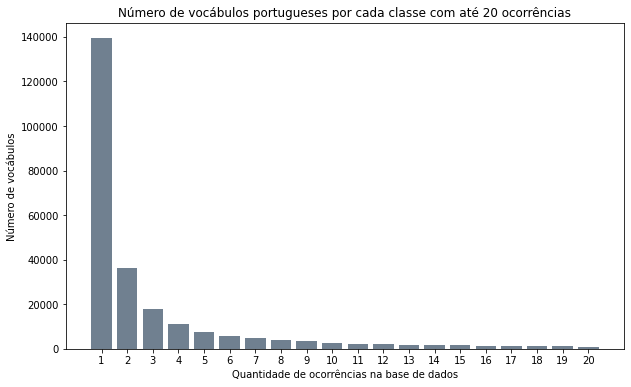

In [ ]:
temp_vocab_pt = sorted(zip(cont_vocabulario_pt, vocabulario_pt))

i_vocabulos = 0
n_ocorrencias = 1
ocorrencias = [0] * 20

while n_ocorrencias <= 20:
    while i_vocabulos < len(temp_vocab_pt):
        if temp_vocab_pt[i_vocabulos][0] == n_ocorrencias:
            ocorrencias[n_ocorrencias - 1] += 1
            i_vocabulos += 1
        else:
            n_ocorrencias += 1
            break
    
plt.figure(figsize=(10, 6))
plt.bar([i for i in range(1, 21)], ocorrencias, color='slategrey')
plt.xlabel("Quantidade de ocorrências na base de dados")
plt.ylabel("Número de vocábulos")
plt.title("Número de vocábulos portugueses por cada classe com até 20 ocorrências")
plt.xticks([i for i in range(1, 21)], [i for i in range(1, 21)])

plt.show()

### Quantidade de vocábulos ingleses com até 20 ocorrências

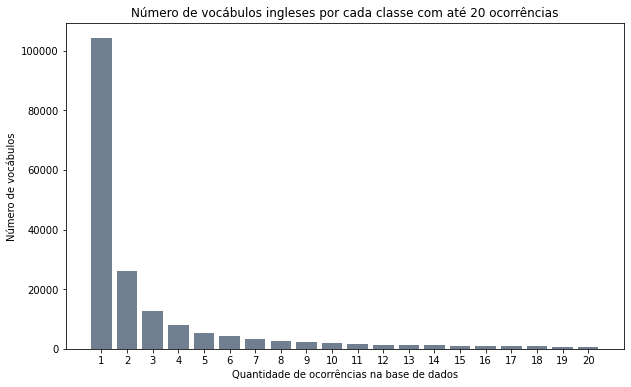

In [ ]:
temp_vocab_en = sorted(zip(cont_vocabulario_en, vocabulario_en))

i_vocabulos = 0
n_ocorrencias = 1
ocorrencias = [0] * 20

while n_ocorrencias <= 20:
    while i_vocabulos < len(temp_vocab_en):
        if temp_vocab_en[i_vocabulos][0] == n_ocorrencias:
            ocorrencias[n_ocorrencias - 1] += 1
            i_vocabulos += 1
        else:
            n_ocorrencias += 1
            break
    
plt.figure(figsize=(10, 6))
plt.bar([i for i in range(1, 21)], ocorrencias, color='slategrey')
plt.xlabel("Quantidade de ocorrências na base de dados")
plt.ylabel("Número de vocábulos")
plt.title("Número de vocábulos ingleses por cada classe com até 20 ocorrências")
plt.xticks([i for i in range(1, 21)], [i for i in range(1, 21)])

plt.show()

## Pré-processamento dos dados para treinamento

In [ ]:
total_linhas_removidas = 0

### Removendo linhas que contém dígitos

##### Como a base é muito grande, a RAM disponível no Colab não dá conta de fazer tokenização e padding pra base completa, então precisamos reduzir o número de linhas. Além disso, há casos onde números que aparecem em uma sentença numa língua são escritos por extenso em outra, fazendo com que a sentença perca o sentido após remover os dígitos durante o pré-processamento.

In [ ]:
i = 0
linhas_removidas = 0
pbar = tqdm(total = len(europarl_pt))
digitos = ['1', '2', '3', '4', '5', '6', '7', '8', '9']

while i < len(europarl_pt):
    pular = False

    for caractere in europarl_pt[i]:
        if caractere in digitos:
            del(europarl_pt[i])
            del(europarl_en[i])
            pular = True
            break

    if not pular:
        for caractere in europarl_en[i]:
            if caractere in digitos:
                del(europarl_pt[i])
                del(europarl_en[i])
                pular = True
                break

    if pular:
        linhas_removidas += 1
    else:
        i += 1
    
    pbar.update(1)
pbar.close()

print("\n\n" + str(linhas_removidas) + " linhas removidas")
total_linhas_removidas += linhas_removidas

100%|██████████| 1960407/1960407 [06:28<00:00, 5050.35it/s] 



228318 linhas removidas


### Removendo caracteres especiais
##### Adaptado de : https://www.tensorflow.org/tutorials/text/nmt_with_attention#download_and_prepare_the_dataset

In [ ]:
pbar = tqdm(total = len(europarl_pt))
counter_pt = Counter()
counter_en = Counter()

for i in range(len(europarl_pt)):
    europarl_pt[i] = ''.join(caractere for caractere in unicodedata.normalize('NFD', europarl_pt[i]) if unicodedata.category(caractere) != 'Mn')
    europarl_en[i] = ''.join(caractere for caractere in unicodedata.normalize('NFD', europarl_en[i]) if unicodedata.category(caractere) != 'Mn')

    # Removendo formatação e convertendo os caracteres para minúsculo
    europarl_pt[i] = europarl_pt[i].strip().lower()
    europarl_en[i] = europarl_en[i].strip().lower()
    
    # Adicionando um espaço entre uma palavra e a pontuação seguinte
    # ex: "he is a boy." => "he is a boy ."
    # Referência: https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    europarl_pt[i] = re.sub(r"([?.!,;])", r" \1 ", europarl_pt[i])
    europarl_en[i] = re.sub(r"([?.!,;])", r" \1 ", europarl_en[i])

    europarl_pt[i] = re.sub(r'[" "]+', " ", europarl_pt[i])
    europarl_en[i] = re.sub(r'[" "]+', " ", europarl_en[i])

    # Substituir tudo por espaço, exceto (a-z, A-Z, ".", "?", "!", ",")
    europarl_pt[i] = re.sub(r"[^a-zA-Z?.!,]+", " ", europarl_pt[i])
    europarl_en[i] = re.sub(r"[^a-zA-Z?.!,]+", " ", europarl_en[i])

    europarl_pt[i] = europarl_pt[i].strip()
    europarl_en[i] = europarl_en[i].strip()

    # Adicionando tokens de início e fim de sentença
    # para que o modelo saiba quando começar e terminar a predição
    europarl_pt[i] = '<inicio> ' + europarl_pt[i] + ' <fim>'
    europarl_en[i] = '<inicio> ' + europarl_en[i] + ' <fim>'

    # Tokenizando
    europarl_pt[i] = europarl_pt[i].split(' ')
    europarl_en[i] = europarl_en[i].split(' ')

    # Contando as ocorrências de cada vocábulo
    counter_pt.update(europarl_pt[i])
    counter_en.update(europarl_en[i])

    pbar.update(1)
pbar.close()

100%|██████████| 1732089/1732089 [04:41<00:00, 6161.60it/s]


### Removendo linhas com mais de 50 vocábulos

##### Como Jean et al., 2015 (https://arxiv.org/abs/1412.2007), Bahdanau et al., 2015 (https://arxiv.org/abs/1409.0473) e Luong et al., 2015 (https://arxiv.org/abs/1508.04025)

In [ ]:
pbar = tqdm(total = len(europarl_pt))
n_linhas_removidas = 0
index = 0

while index < len(europarl_pt):
    if len(europarl_pt[index]) > 50 or len(europarl_en[index]) > 50:
        n_linhas_removidas += 1
        del(europarl_pt[index])
        del(europarl_en[index])
    else:
        index += 1
    pbar.update(1)
pbar.close()

print("Número de linhas com mais de 50 tokens removidas : " + str(n_linhas_removidas))

Número de linhas com mais de 50 tokens removidas : 195470


### Construindo o vocabulário com os 50.000 vocábulos mais comuns

##### Assim como Luong et al., 2015 (https://arxiv.org/abs/1508.04025) e Jean et al., 2015 (https://arxiv.org/abs/1412.2007). 

In [ ]:
mais_frequentes_pt = [vocabulo for (vocabulo, cont) in counter_pt.most_common(50000)]
mais_frequentes_en = [vocabulo for (vocabulo, cont) in counter_en.most_common(50000)]

dict_pt = dict()
dict_en = dict()

dict_pt = ({'': 0, '<desconhecido>': 1})
dict_pt[0] = ''
dict_pt[1] = '<desconhecido>'

dict_en = ({'': 0, '<desconhecido>': 1})
dict_en[0] = ''
dict_en[1] = '<desconhecido>'

index_pt = 2
index_en = 2

for i in range(50000):
    dict_pt[i + 2] = mais_frequentes_pt[i]
    dict_pt[mais_frequentes_pt[i]] = i + 2

    dict_en[i + 2] = mais_frequentes_en[i]
    dict_en[mais_frequentes_en[i]] = i + 2

### Tokenização e padding

##### Vamos preencher as linhas com zeros para que todas tenham 50 tokens. Isso é necessário porque as técnicas de aprendizado profundo não se dão bem com matrizes não-quadradas.

In [ ]:
pbar = tqdm(total = len(europarl_pt))

for i in range(len(europarl_pt)):
    for index_token in range(len(europarl_pt[i])):
        if europarl_pt[i][index_token] in dict_pt:
            europarl_pt[i][index_token] = dict_pt[europarl_pt[i][index_token]]
        else:
            europarl_pt[i][index_token] = dict_pt['<desconhecido>']
    europarl_pt[i] += [0] * (50 - len(europarl_pt[i]))
    
    
    for index_token in range(len(europarl_en[i])):
        if europarl_en[i][index_token] in dict_en:
            europarl_en[i][index_token] = dict_en[europarl_en[i][index_token]]
        else:
            europarl_en[i][index_token] = dict_en['<desconhecido>']
    europarl_en[i] += [0] * (50 - len(europarl_en[i]))

    pbar.update(1)
pbar.close()

100%|██████████| 1536619/1536619 [00:56<00:00, 27246.57it/s]


### Adicionando mais uma dimensão à base de dados
<ul>
<li> Redes recorrentes precisam de vetores em 3d, então transformaremos os os vetores com formato (número_de_linhas, número_de_vocábulos) em (número_de_linhas, número_de_vocábulos, 1), onde 1 é o vocábulo para cada etapa da sequência. </li></ul>

In [ ]:
europarl_pt = np.expand_dims(np.array(europarl_pt), -1)
europarl_en = np.expand_dims(np.array(europarl_en), -1)
print(europarl_pt.shape)
print(europarl_en.shape)

(1536619, 50, 1)
(1536619, 50, 1)


### Separação de amostras de treino e teste

In [ ]:
base_pt_treino, base_pt_teste, base_en_treino, base_en_teste = train_test_split(europarl_pt, europarl_en, test_size=0.3)

### Salvando a base tokenizada e o tokenizador

In [ ]:
europarl_pt = np.array(europarl_pt)
europarl_en = np.array(europarl_en)

np.save(raiz + '50v_sd_sce_padded_pt.npy', europarl_pt, allow_pickle=True)
np.save(raiz + '50v_sd_sce_padded_en.npy', europarl_en, allow_pickle=True)

np.save(raiz + '50v_sd_sce_padded_pt_treino.npy', base_pt_treino, allow_pickle=True)
np.save(raiz + '50v_sd_sce_padded_en_treino.npy', base_en_treino, allow_pickle=True)
np.save(raiz + '50v_sd_sce_padded_pt_teste.npy', base_pt_teste, allow_pickle=True)
np.save(raiz + '50v_sd_sce_padded_en_teste.npy', base_en_teste, allow_pickle=True)

with open(raiz + 'dicionario_tokenizador_pt.json', 'wt') as arq_dict_pt:
    json.dump(dict_pt, arq_dict_pt)

with open(raiz + 'dicionario_tokenizador_en.json', 'wt') as arq_dict_en:
    json.dump(dict_en, arq_dict_en)

### Carregando a base salva
<ul>
<li> Python automaticamente converte índices numéricos de dicionários em strings ao salvar em arquivo, então precisamos reconverter estes índices em numéricos ao carregar um dicionário salvo.</li></ul>

In [ ]:
#europarl_pt = np.load(raiz + '50v_sd_sce_padded_pt.npy', allow_pickle=True)
#europarl_en = np.load(raiz + '50v_sd_sce_padded_en.npy', allow_pickle=True)
X_treino = np.load(raiz + '50v_sd_sce_padded_en_treino.npy', allow_pickle=True)
X_teste = np.load(raiz + '50v_sd_sce_padded_en_teste.npy', allow_pickle=True)
y_treino = np.load(raiz + '50v_sd_sce_padded_pt_treino.npy', allow_pickle=True)
y_teste = np.load(raiz + '50v_sd_sce_padded_pt_teste.npy', allow_pickle=True)

with open(raiz + 'dicionario_tokenizador_pt.json', 'rt') as arq_dict_pt:
    dict_pt = json.load(arq_dict_pt)

with open(raiz + 'dicionario_tokenizador_en.json', 'rt') as arq_dict_en:
    dict_en = json.load(arq_dict_en)

In [ ]:
index = 0

while str(index) in dict_pt:
    dict_pt[index] = dict_pt[str(index)]
    del(dict_pt[str(index)])
    index += 1

index = 0

while str(index) in dict_en:
    dict_en[index] = dict_en[str(index)]
    del(dict_en[str(index)])
    index += 1

In [ ]:
"""
X_treino = np.load(raiz + '50v_sd_sce_padded_en_treino.npy', allow_pickle=True)
X_teste = np.load(raiz + '50v_sd_sce_padded_en_teste.npy', allow_pickle=True)
y_treino = np.load(raiz + '50v_sd_sce_padded_pt_treino.npy', allow_pickle=True)
y_teste = np.load(raiz + '50v_sd_sce_padded_pt_teste.npy', allow_pickle=True)"""

tam_batch = 64

X_treino = tf.convert_to_tensor(np.squeeze(X_treino), dtype = tf.dtypes.int64)
X_teste = tf.convert_to_tensor(np.squeeze(X_teste), dtype = tf.dtypes.int64)

y_treino = tf.convert_to_tensor(np.squeeze(y_treino), dtype = tf.dtypes.int64)
y_teste = tf.convert_to_tensor(np.squeeze(y_teste), dtype = tf.dtypes.int64)

dataset_treino = tf.data.Dataset.from_tensor_slices((X_treino, y_treino)).batch(tam_batch, drop_remainder = True)
dataset_teste = tf.data.Dataset.from_tensor_slices((X_teste, y_teste)).batch(tam_batch, drop_remainder = True)

## Componentes customizados

### Encoder

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, 
                 num_celulas, 
                 tipo_celula='lstm',
                 num_dim_embedding = 0,
                 tam_vocab = 0,
                 dropout = 0.0,
                 nome='Encoder'):
        
        self.num_celulas = num_celulas
        self.tipo_celula = tipo_celula.lower()
        
        if self.tipo_celula == 'lstm':
            self.encoder = tf.keras.layers.LSTM(num_celulas,
                                                return_sequences=True,
                                                return_state=True,
                                                dropout=dropout)
        
        if self.tipo_celula == 'gru':
            self.encoder = tf.keras.layers.GRU(num_celulas,
                                               return_sequences=True,
                                               return_state=True,
                                               dropout=dropout) 
            
        if num_dim_embedding > 0:
            self.embedding = tf.keras.layers.Embedding(tam_vocab, 
                                                       num_dim_embedding, 
                                                       mask_zero = True)

        super(Encoder, self).__init__(name=nome, trainable=True, dynamic=True)

    def call(self, inputs, training=False):
        x = self.embedding(inputs)
        mascara = self.embedding.compute_mask(inputs)

        if self.tipo_celula == 'lstm':
            saida, estado_oculto, estado_celula = self.encoder(x, 
                                                               mask = mascara,
                                                               training = training)
            estado_final = [estado_oculto, estado_celula]
        elif self.tipo_celula == 'gru':
            saida, estado_final = self.encoder(x, 
                                               mask = mascara,
                                               training=training)

        return saida, estado_final

### Decoder

In [ ]:
class ProfessorForcingDecoder(tf.keras.layers.Layer):
    def __init__(self, 
                 num_celulas, 
                 token_inicio, 
                 token_fim,
                 tipo_celula = 'lstm',
                 num_dim_embedding = 0,
                 tam_vocab = 0,
                 tamanho_batch = 64,
                 dropout = 0.0,
                 atencao='none',
                 janelas_atencao = 0,
                 dropout_atencao = 0.0,
                 limite_maximo = 200,
                 nome = 'ProfessorForcingDecoder'):
        
        self.num_celulas = num_celulas
        self.tipo_celula = tipo_celula.lower()
        self.tam_batch = tamanho_batch
        self.tam_vocab = tam_vocab
        self.atencao = None
        self.token_inicio = token_inicio
        self.token_fim = token_fim
        self.limite_maximo = limite_maximo

        self.classificador = tf.keras.layers.Dense(tam_vocab, activation='softmax')
        self.classificador_temporal = tf.keras.layers.TimeDistributed(self.classificador)
        self.funcao_perda = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')
        
        if self.tipo_celula == 'lstm':
            self.decoder = tf.keras.layers.LSTM(num_celulas,
                                                return_sequences=True,
                                                return_state=True,
                                                dropout=dropout)
        
        if self.tipo_celula == 'gru':
            self.decoder = tf.keras.layers.GRU(num_celulas,
                                               return_sequences=True,
                                               return_state=True,
                                               dropout=dropout) 

        if atencao.lower() == 'luong':
            self.atencao = tf.keras.layers.Attention(janelas_atencao, dropout=dropout_atencao)

        elif atencao.lower() == 'bahdanau':
            self.atencao = tf.keras.layers.AdditiveAttention(janelas_atencao, dropout=dropout_atencao)

        if num_dim_embedding > 0:
            self.embedding = tf.keras.layers.Embedding(tam_vocab, 
                                                       num_dim_embedding, 
                                                       mask_zero = True)

        super(ProfessorForcingDecoder, self).__init__(name=nome, trainable=True, dynamic=True)

    def decode(self, x, estado_final_anterior, training = False, mask = None):
        if self.tipo_celula == 'lstm':
            x, estado_oculto, estado_celula = self.decoder(x, 
                                                           estado_final_anterior,
                                                           mask = mask,
                                                           training = False)
            estado_final = [estado_oculto, estado_celula]

        elif self.tipo_celula == 'gru':
            x, estado_final = self.decoder(x, 
                                           estado_final_anterior,
                                           mask = mask, 
                                           training = False)
        return x, estado_final

    def call(self, inputs, saida_decoder, estado_final_anterior, training=False):
        if training:
            x = self.embedding(inputs)
            mascara = self.embedding.compute_mask(inputs)
            """
            if self.atencao:
                contexto_atencao = self.atencao([tf.expand_dims(estado_final_anterior, 1), saida_decoder])
                x = tf.concat([tf.expand_dims(contexto_atencao, 1), x], axis=-1)"""
            saida, _ = self.decode(x, 
                                   estado_final_anterior, 
                                   mask = mascara,
                                   training = True)

            saida = self.classificador_temporal(saida)[:,:-1]

        elif inputs is not None:
            saida = np.zeros((1, self.tam_batch, self.tam_vocab), dtype = np.float32)
            saida[0][0][self.token_inicio] = 1.0
            saida = tf.convert_to_tensor(saida, dtype = tf.dtypes.float32)
            x = tf.convert_to_tensor([[self.token_inicio]] * self.tam_batch) # A entrada inicial tem formato (tam_batch)
                                                                           # e é preenchida com o token de início

            estado_final = estado_final_anterior # O estado oculto/final da rede recorrente

            for _ in range(inputs.shape[1]):
                mascara = self.embedding.compute_mask(x) # Usando máscara para a rede recorrente ignorar os zeros
                x = self.embedding(x) 
                x, estado_final = self.decode(x, 
                                              estado_final, 
                                              mask = mascara,
                                              training = False)
                    
                x = tf.squeeze(x, [1]) # Convertendo a saída da rede recorrente de (tam_batch, 1, num_celulas)
                                       # para (tam_batch, num_celulas)

                x = self.classificador(x) # A saída do classificador tem formato (tam_batch, tam_vocab)
                saida = tf.concat([saida, tf.expand_dims(x, axis = 0)], axis = 0)
                x = tf.math.argmax(x, axis = -1, output_type = tf.dtypes.int64)
                x = tf.expand_dims(x, axis = 1)
            
            saida = tf.transpose(saida[1:-1], [1, 0, 2]) # Removendo a primeira posição que foi criada só para inicializar o tensor

        else:
            saida = np.zeros((1, self.tam_vocab), dtype = np.float32)
            saida[0][self.token_inicio] = 1.0
            saida = tf.convert_to_tensor(saida, dtype = tf.dtypes.float32)
            x = tf.convert_to_tensor([[self.token_inicio]], dtype = tf.dtypes.int64)
            estado_final = estado_final_anterior
            limitador = 0

            while x != tf.constant([self.token_fim], dtype = tf.dtypes.int64) and limitador < 200:
                mascara = self.embedding.compute_mask(x) # Usando máscara para a rede recorrente ignorar os zeros
                x = self.embedding(x) 

                x, estado_final = self.decode(x, 
                                              estado_final, 
                                              mask = mascara,
                                              training = False)
                    
                x = tf.squeeze(x, [1]) # Convertendo a saída da rede recorrente de (tam_batch, 1, num_celulas)
                                       # para (tam_batch, num_celulas)

                x = self.classificador(x) # A saída do classificador tem formato (tam_batch, tam_vocab)
                saida = tf.concat([saida, x], axis = 0)
                x = tf.math.argmax(x, axis = -1, output_type = tf.dtypes.int64)
                x = tf.expand_dims(x, axis = 1)
                limitador += 1
            
            saida = saida[:,1:-1] # Removendo a primeira posição que foi criada só para inicializar o tensor
                                  # e a última que é o token final
        if inputs is not None:
            perda = self.funcao_perda(inputs[:,1:], saida)
            return tf.math.argmax(saida, axis = -1, output_type = tf.dtypes.int64), tf.reduce_mean(perda)
        else:
            return tf.math.argmax(saida, axis = -1, output_type = tf.dtypes.int64), 0.0        

### BLEU

##### Papinemi et al., 2002 (https://dl.acm.org/doi/10.3115/1073083.1073135)

In [ ]:
def calcular_bleu(tensor_referencias, tensor_candidatos, ngrams = 4):
    referencias = tensor_referencias.numpy()
    candidatos = tensor_candidatos.numpy()
    batch_bleu = 0
    peso = 1 / ngrams
    
    for index in range(len(referencias)):
        bleu = 0

        for ngram in range(1, ngrams + 1):
            referencia = montar_ngram(referencias[index], ngram = ngram)
            candidato = montar_ngram(candidatos[index], ngram = ngram)
            count = 0

            for gram_candidato in montar_conjunto(candidato):
                count += referencia.count(gram_candidato)

            if len(montar_conjunto(candidato)) > 0 and count > 0:
                count = count / len(montar_conjunto(candidato))
                bleu += (peso * np.log(count))

        r = len(montar_conjunto(referencias[index]))
        c = len(montar_conjunto(candidatos[index]))

        if c > 0:
            bp = 1 if c > r else np.exp((1 - r)/c)
            bleu = bp * np.exp(bleu)
            batch_bleu += bleu 
        else:
            pass              

    return batch_bleu/len(referencias)

def montar_ngram(vetor, ngram = 2, remover_zeros = True):
    novo_vetor = []
    vetor_ngram = []

    for elemento in vetor:
        if elemento != 0:
            novo_vetor.append(elemento)
    
    for i in range(len(novo_vetor) - ngram + 1 ):
        vetor_ngram.append(tuple(novo_vetor[i:i+ngram]))

    return vetor_ngram

def montar_conjunto(vetor):
    conjunto = set()

    for elemento in vetor:
        if elemento not in conjunto:
            conjunto.add(elemento)

    return conjunto

## Testes
<ul>
<li> Todas as instâncias utilizam professor forcing (<a href="https://arxiv.org/abs/1610.09038">Lamb et al., 2016</a>) </li>
<ul>



### Baseline - encoder/decoder LSTM

In [ ]:
encoder = Encoder(1024, 
                  tipo_celula = 'gru', 
                  num_dim_embedding = 256, 
                  tam_vocab = len(dict_pt)//2 + 1)

decoder = ProfessorForcingDecoder(1024, 
                                  dict_pt["<inicio>"],
                                  dict_pt["<fim>"],
                                  tipo_celula = 'gru', 
                                  tamanho_batch = tam_batch,
                                  num_dim_embedding = 256, 
                                  tam_vocab = len(dict_pt)//2 + 1)

##### Otimizador
Utilizando os mesmos parâmetros que Bahdanau et al., 2015 (https://arxiv.org/abs/1409.0473)

In [ ]:
otimizador = tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95, epsilon=1e-06)

##### Função de treino

In [ ]:
@tf.function
def treinar(entrada, saida):
    threshold = 1.0
    perda = 0
    bleu = 0

    with tf.GradientTape() as tape:
        saida_encoder, estados_encoder = encoder(entrada, training = True)
        saida_decoder, perda = decoder(saida, saida_encoder, estados_encoder, training = True)

    variaveis = encoder.trainable_variables + decoder.trainable_variables

    gradientes = tape.gradient(perda, variaveis)

    gradientes = [tf.clip_by_norm(gradiente, threshold) if tf.math.reduce_max(gradiente) > threshold else gradiente for gradiente in gradientes]

    otimizador.apply_gradients(zip(gradientes, variaveis))

    return perda, saida_decoder

#### Função de teste/avaliação

In [ ]:
def avaliar(entrada, saida):
    perda = 0
    
    saida_encoder, estados_encoder = encoder(entrada, training = False)
    saida_decoder, perda = decoder(saida, saida_encoder, estados_encoder, training = False)

    return perda, saida_decoder

#### Treinamento

In [ ]:
num_epocas = 1

print(str(num_epocas) + " época(s) executando " + str(X_treino.shape[0]) + " amostras de treino e " + str(X_teste.shape[0]) + " amostras de teste\n")

for epoca in range(num_epocas):
    print("Época " + str(epoca + 1) + " iniciando\n")
    perda_total = 0
    perda_total_teste = 0
    bleu_total = 0
    bleu_total_teste = 0
    executados = 0
    executados_teste = 0

    pbar = tf.keras.utils.Progbar(X_treino.shape[0], stateful_metrics = ['perda', 'bleu'])
    pbar.update(0, values = [('perda', np.inf), ('bleu', 0)])

    for batch in dataset_treino:
        x, y = batch
        executados += x.shape[0]
        perda, saida_decoder = treinar(x, y)
        bleu = calcular_bleu(y[:,1:], saida_decoder)
        bleu_total += bleu
        perda_total += perda
        pbar.update(executados, values = [('perda', perda.numpy()), ('bleu', bleu)])

    pbar.update(executados, finalize = True)
    perda_total /= math.ceil(executados/tam_batch)
    bleu_total /= math.ceil(executados/tam_batch)
    print("\nperda média = %.3f" % perda_total)
    print("bleu médio = %.3f" % bleu_total)

    print("\n Iniciando avaliação da época " + str(epoca + 1) + "\n")

    pbar = tf.keras.utils.Progbar(X_teste.shape[0], stateful_metrics = ['perda', 'bleu'])
    pbar.update(0, values = [('perda', np.inf), ('bleu', 0)])

    for batch in dataset_teste:
        x, y = batch
        executados_teste += x.shape[0]
        perda, saida_decoder = avaliar(x, y)
        bleu = calcular_bleu(y, saida_decoder)
        bleu_total_teste += bleu
        perda_total_teste += perda
        pbar.update(executados_teste, values = [('perda teste', perda.numpy()), ('bleu teste', bleu)])
    
    pbar.update(executados_teste, finalize = True)
    perda_total_teste /= math.ceil(executados_teste/tam_batch)
    bleu_total_teste /= math.ceil(executados_teste/tam_batch)
    print("\nperda média teste = %.3f" % perda_total_teste)
    print("bleu médio teste = %.3f" % bleu_total_teste)

1 época(s) executando 1075633 amostras de treino e 460986 amostras de teste

Época 1 iniciando

     64/1075633 [..............................] - ETA: 44:33:03 - perda: 10.8206 - bleu: 0.0000e+00

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log


1075584/1075633 [============================>.] - ETA: 0s - perda: 2.1660 - bleu: 0.0085
perda total = 2.520
bleu total = 0.003

 Iniciando avaliação da época 1

177664/460986 [==========>...................] - ETA: 1:37:41 - perda: inf - bleu: 0.0000e+00 - perda teste: 10.4656 - bleu teste: 0.0019

KeyboardInterrupt: ignored

In [ ]:
perda, saida = avaliar(X_teste[:64], y_teste[:64])

In [ ]:
_, saida = avaliar(X_teste[:1], None)

In [ ]:
traducao = ' '.join([dict_pt[index] for index in saida.numpy()[2]])
original = ' '.join([dict_pt[index] for index in y_teste[2].numpy()])
print(original)
print(traducao)

<inicio> recusando nos a criar um regime concorrencial , propusemos que se assegurasse a igualdade de abastecimento e fornecimento ao melhor preco , a igualdade de tratamento dos consumidores e a perequacao tarifaria . <fim>               
a comissao europeia , a comissao , a comissao , a comissao , a comissao , a comissao , a comissao , a comissao , a comissao , a comissao , a comissao , a comissao , a comissao , a comissao , a comissao , a comissao ,


In [ ]:
len([dict_pt[index] for index in saida.numpy()[0]])

49

In [ ]:
calcular_bleu(tf.expand_dims(X_teste[0], axis = 0), tf.expand_dims(saida[0], axis = 0))

0.20492499184526708